# Library imports

In [ ]:
!pip install contractions
!pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils import pad_sequences
from keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,SimpleRNN,Embedding,Flatten, Dropout, Bidirectional, Conv1D, MaxPooling1D
from bs4 import BeautifulSoup
import unicodedata
import tqdm
import contractions
import re

# Load the dataset

Source: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/archive/train.csv',encoding = 'unicode_escape')
test_data = pd.read_csv('/content/drive/MyDrive/Dataset/archive/test.csv',encoding = 'unicode_escape')

In [ ]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
col = ['text','sentiment']
data = data[col]
data = data[data['sentiment'] != 'neutral']
test_data = test_data[col]
test_data = test_data[test_data['sentiment']!= 'neutral']

In [ ]:
test_data.dropna(inplace=True)

In [ ]:
data.head()

,text,sentiment
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
6,2am feedings for the baby are fun when he is a...,positive


# Data visualization

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16363 entries, 1 to 27479
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       16363 non-null  object
 1   sentiment  16363 non-null  object
dtypes: object(2)
memory usage: 383.5+ KB


In [ ]:
data.shape

(16363, 2)

In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
positive,8582
negative,7781


In [ ]:
data.describe()

,text,sentiment
count,16363,16363
unique,16363,2
top,Sooo SAD I will miss you here in San Diego!!!,positive
freq,1,8582


In [ ]:
data.isnull().sum()

,0
text,0
sentiment,0


# Data preprocessing

## Removing null value

In [ ]:
data.isnull().sum()

,0
text,0
sentiment,0


In [ ]:
data.dropna(inplace=True)

## Balancing dataset

In [ ]:
RUS = RandomUnderSampler(random_state=24)
x = data.drop(columns=['sentiment'])
y = data['sentiment']

x_resampled,y_resampled = RUS.fit_resample(x,y)

data = pd.concat([x_resampled, y_resampled], axis=1, join='inner')

In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
negative,7781
positive,7781


In [ ]:
encoder = LabelEncoder()
data['sentiment'] = encoder.fit_transform(data['sentiment'])
test_data['sentiment'] = encoder.transform(test_data['sentiment'])

## Splitting dataset into train and test

In [ ]:
#shuffle
data = data.sample(frac=1).reset_index(drop=True)

split_size = int(0.7*(len(data)))

x_train = data['text'][:split_size]
y_train = data['sentiment'][:split_size]

x_test = data['text'][split_size:]
y_test = data['sentiment'][split_size:]

## Reformating, cleaning text

In [ ]:
## function for cleaning text
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
x_val = test_data['text']

x_train = pre_process_corpus(x_train.values)
x_test = pre_process_corpus(x_test.values)
x_val = pre_process_corpus(x_val.values)

  0%|          | 0/10893 [00:00<?, ?it/s]<ipython-input-19-83555214956f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 2104/2104 [00:00<00:00, 2225.98it/s]


## Tokenize text

In [ ]:
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(x_train)
t.word_index['<PAD>'] = 0

In [ ]:
x_train = t.texts_to_sequences(x_train)
x_test = t.texts_to_sequences(x_test)
x_val = t.texts_to_sequences(x_val)

In [ ]:
print("Vocabulary size = {}".format(len(t.word_index)))
print("Number of text = {}".format(t.document_count))

Vocabulary size = 15865
Number of text = 10893


## Padding sequence

In [ ]:
MAX_SEQUENCE_LENGTH = 40

x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
x_val = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)

## Setting up parameters for embedding layer

In [ ]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 40

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 2

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

# Building the model

In [ ]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),

    Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'),

    MaxPooling1D(pool_size=2),

    Dropout(rate=0.10),

    Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'),

    MaxPooling1D(pool_size=2),

    Dropout(rate=0.10),

    Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'),

    MaxPooling1D(pool_size=2),

    Dropout(rate=0.10),

    Flatten(),

    Dense(256, activation='relu'),

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(35e-6), metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size = 64, validation_data=(x_test, y_test),verbose=1, callbacks=[callback])

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.5086 - loss: 0.6929 - val_accuracy: 0.5252 - val_loss: 0.6928
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5156 - loss: 0.6927 - val_accuracy: 0.5429 - val_loss: 0.6918
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.5439 - loss: 0.6910 - val_accuracy: 0.5740 - val_loss: 0.6872
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6078 - loss: 0.6818 - val_accuracy: 0.7113 - val_loss: 0.6468
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7372 - loss: 0.6038 - val_accuracy: 0.7931 - val_loss: 0.4776
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8337 - loss: 0.4128 - val_accuracy: 0.8342 - val_loss: 0.3924
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8720 - loss: 0.3177 - val_accuracy: 0.8426 - val_loss: 0.3632
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8992 - loss: 0.2603 - val_ac

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 40, 40)              │         634,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 40, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,240,669 (8.55 MB)

 Trainable params: 746,889 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,493,780 (5.70 MB)

Text(0, 0.5, 'ACCURACY')

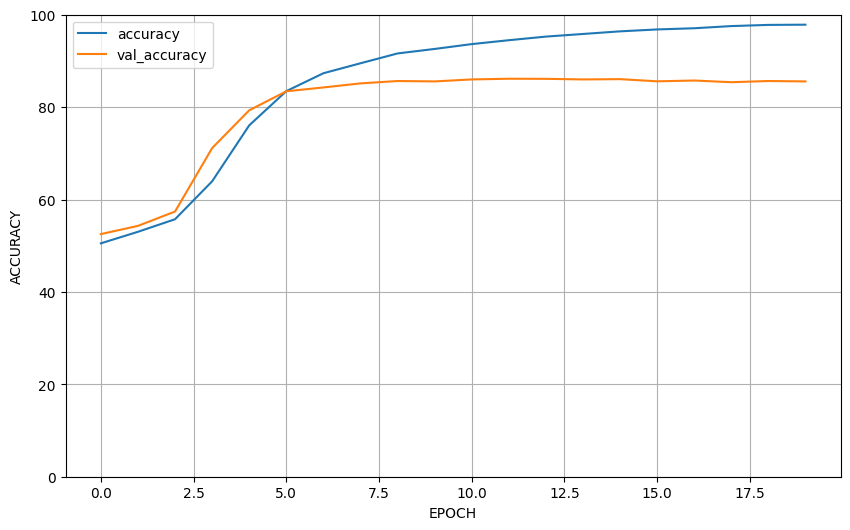

In [ ]:
metrics = history.history
plt.figure(figsize=(10,6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics ['val_accuracy']))
plt.legend(['accuracy','val_accuracy'])
plt.grid(visible=True)
plt.ylim(0,100)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')

In [ ]:
y_val = test_data['sentiment']
scores = model.evaluate(x_val, y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8690 - loss: 0.3688
Accuracy: 86.60%
